In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.sim_drifter as sdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*1)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster


In [4]:
client

Client Scheduler: tcp://10.148.1.64:55979 Dashboard: http://10.148.1.64:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
dr = sdr.drifter_dataframe(root_path+run, tdir_max=1)

In [39]:
# Definition parameters
t0 = 1501 #initial time
t1 = 1520 # final time
tmid = (t0+t1)/2 # mid period
flt_id = 225 # test drifter id

#### Functions to compute initial, final, maximal and minimal latitudes for each drifters over a period of time

In [44]:
def time_window_processing(df, myfun, tmin,tmax):
    ''' break each drifter time series into time windows and process each windows
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        myfun
            Method that will be applied to each window
            
        tmin
    
    '''
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name
    p = df.sort_values('time').set_index('time')
    _p = p.loc[tmin:tmax]
    # need to create an empty dataframe, in case the loop below is empty
    #latmax,latmin,lat0,lat1 = myfun(_p) # get index from fake output
    myfun_out = myfun(_p)
#    index = ['x','y']+list(myfun_out.index)
    out = pd.DataFrame({'latmax':[myfun_out[0]],'latmin':[myfun_out[1]],'lati':[myfun_out[2]],'latf':[myfun_out[3]]},index = df.id.unique())
#[list(myfun_out)])
    return out

def diags_dist(flt):
#    fltI = flt.sel(time=slice(Ti,Tf))
    return pd.Series([flt.y.max(),flt.y.min(),flt.y.loc[t0],flt.y.loc[t1]])#,fltI.v

#### test the function for one drifter (flt_id)

In [9]:
df0 = dr.df.groupby('id').get_group(flt_id).compute()

In [45]:
out = time_window_processing(df0, diags_dist, t0,t1)
out

,latmax,latmin,lati,latf
225,1956.63616,1934.11788,1941.903,1955.17516


#### Apply the function to each drifter : 

In [46]:
df_chunked = dr.df.groupby('id').apply(time_window_processing, diags_dist, t0, t1)

ValueError: Metadata inference failed in `groupby.apply(time_window_processing)`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError(1501.0)

Traceback:
---------
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/dask/dataframe/utils.py", line 172, in raise_on_meta_error
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/dask/dataframe/groupby.py", line 1576, in apply
    meta = self._meta_nonempty.apply(func, *meta_args, **meta_kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 735, in apply
    result = self._python_apply_general(f)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 751, in _python_apply_general
    keys, values, mutated = self.grouper.apply(f, self._selected_obj, self.axis)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/ops.py", line 206, in apply
    res = f(group)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 719, in f
    return func(g, *args, **kwargs)
  File "<ipython-input-44-9d09086192e1>", line 24, in time_window_processing
    myfun_out = myfun(_p)
  File "<ipython-input-44-9d09086192e1>", line 32, in diags_dist
    return pd.Series([flt.y.max(),flt.y.min(),flt.y.loc[t0],flt.y.loc[t1]])#,fltI.v
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/indexing.py", line 1767, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/indexing.py", line 1964, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/indexing.py", line 620, in _get_label
    return self.obj._xs(label, axis=axis)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/generic.py", line 3537, in xs
    loc = self.index.get_loc(key)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/indexes/numeric.py", line 508, in get_loc
    return super().get_loc(key, method=method, tolerance=tolerance)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2648, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))
  File "pandas/_libs/index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 385, in pandas._libs.hashtable.Float64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 392, in pandas._libs.hashtable.Float64HashTable.get_item


### Number of drifters in (30x30) bins at t0

In [ ]:
dr.init_bins(y={'min':0, 'max': 2800, 'step': 30}, x={'min':0, 'max': 1000, 'step': 30})

In [10]:
df0 = dr.df.groupby('time').get_group(t0).compute()

In [15]:
df1 = dr.df.groupby('time').get_group(t1).compute()

In [17]:
flt0 = df0.sort_values('id').set_index('id')
flt1 = df1.sort_values('id').set_index('id')

In [28]:
count_bins0 = df0.groupby(['x_cut','y_cut'])['id'].agg('count').rename({'id': 'id_count'}).to_xarray()

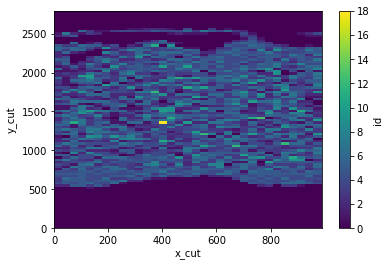

In [31]:
count_bins0.plot(y='y_cut')

### This part contains tests used in the previous part,this is just visualization of different trajectories and informations on those trajectories.

In [9]:
# tests on one drifter
flt1 = dr.df.groupby('id').get_group(flt_id).compute().sort_values('time').set_index('time')

In [10]:
# Informations on drifter trajectory:
flti = flt1.loc[t0:t1]
latmin,latmax, lat0,lat1, latmid = flti.y.min(),flti.y.max(), flt1.loc[t0].y, flt1.loc[t1].y, flt1.loc[tmid].y
#print('Minimum latitude : ',latmin,';  Maximum latitude : ',latmax,';  Latitude at t0 : ', lat0,
#      ';  Laitude at t1 : ', lat1';  Latitude at tmid : ',latmid)

#### Plot of latitude maximum, minimum and at mid period of one drifter

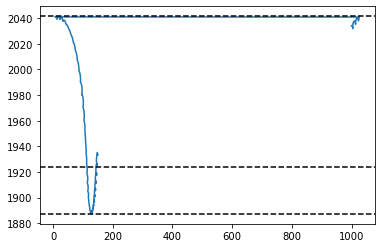

In [11]:
fig,ax  = plt.subplots()
ax.plot(flti.x,flti.y)
ax.axhline(y=latmax,c='k',linestyle='--')
ax.axhline(y=latmin,c='k',linestyle='--')
ax.axhline(y=latmid,c='k',linestyle='--')

#### Definition of the drifters postions at t0

In [13]:
df0 = dr.df.groupby('time').get_group(t0).compute().sort_values('y').set_index('y')

In [31]:
dr.init_bins(y={'min':0, 'max': 2800, 'step': 30}, x={'min':0, 'max': 1000, 'step': 30},
             time={'min':0, 'max': 1000, 'step': 1})

In [ ]:
dr.df.groupby(['id'])['y'].agg(['mean','min','max']).compute()#.loc[t0:t1]

In [ ]:
# Distance between inital drifter position (x0,y0) and position at time t (x,y)
def distance(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

In [ ]:
plt.plot(distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum())
distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum().shape

In [11]:
df0 = dr.df.groupby('time').get_group(flt1.index.min()).compute().sort_values('y').set_index('y')
#id0 = dr.df.groupby('time').get_group(flt1.index.min()).id

In [12]:
lat = [725,1215,1515,1715,2100]

In [13]:
DF0 = df0.to_xarray()#.sel(y=lat,method='nearest')

In [21]:
#DF0.sel(y=0,method='nearest')
yi = DF0.y[10::1800]
idi = DF0.id[10::1800]

In [ ]:
# Get several drifters
ds = {}
for i in idi[:2]:
    ds['flt_%s'%int(i.values)] = dr.df.groupby('id').get_group(int(i.values)).compute().sort_values('time').set_index('time').to_xarray()
ds

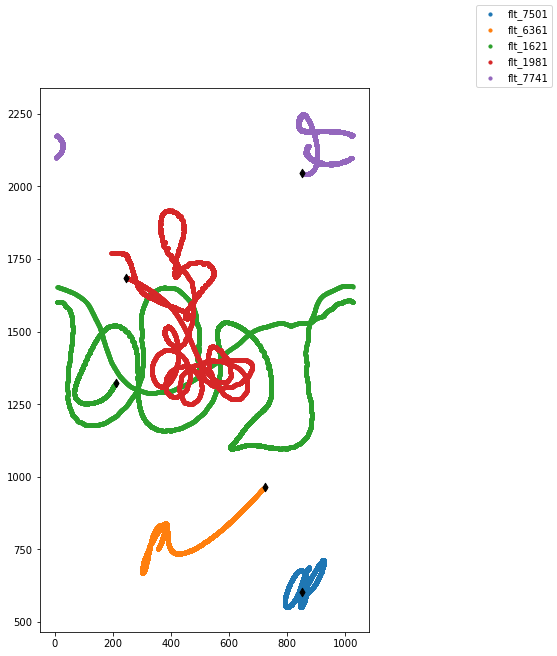

In [153]:
#Plot several drifters trajectories 
#(illustration of different trajectories depending on the initial latitude)
ti, tf = 1500,1600
fig,ax = plt.subplots(figsize=(10,10))
for d in ds :
    ax.scatter(ds['%s'%d].x.sel(time=slice(ti,tf)),ds['%s'%d].y.sel(time=slice(ti,tf)),
               s=10,label=str(d))
    ax.scatter(ds['%s'%d].x[0],ds['%s'%d].y[0],c='k',marker='d')
ax.set_aspect('equal')
fig.legend()

In [148]:
#Compute the latitudes for the chosen drifter(s) and wrap function to plot latitude max and min (dashed lines)
#and initial position (red point) (left figure) and dy/dt (v) (right figure)
def diags_dist(flt,Ti,Tf):
    fltI = flt.sel(time=slice(Ti,Tf))
    return fltI.y.max().values,fltI.y.min().values,fltI.y[0].values,fltI.y[-1].values,fltI.v
def plot_dist(flt,Ti,Tf,figsize):
    fltI = flt.sel(time=slice(Ti,Tf))
    latmax,latmin, lat0,lat1, dydt = diags_dist(flt,Ti,Tf)
    fig = plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,2,1)
    ax.plot(fltI.x,fltI.y)
    ax.axhline(y=latmax,c='k',linestyle='--')
    ax.axhline(y=latmin,c='k',linestyle='--')
    ax.scatter(fltI.x[0],fltI.y[0],c='r')
    ax.set_ylabel(r'${y_\rho}$ (km)');ax.set_xlabel(r'${x_\rho}$ (km)')
    ax = fig.add_subplot(1,2,2)
    ax.plot(fltI.time,dydt)
    ax.set_ylabel('dy/dt');ax.set_xlabel('Time (days)')

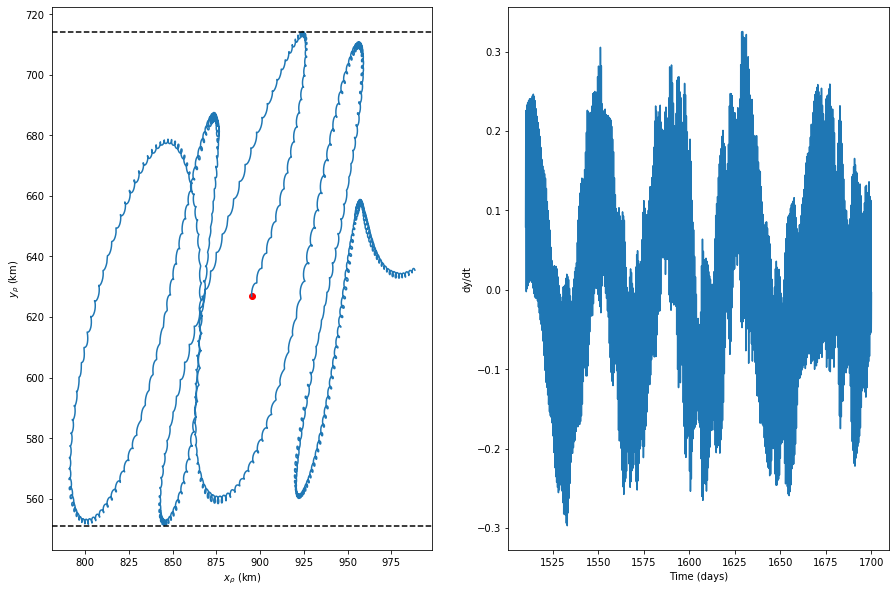

In [154]:
plot_dist(ds['flt_7501'],1510,1700,(15,10))

In [ ]:
cluster.close()